# Assignment 5
## Group Members:
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
### Chukwudumebi Ubogu, e-mail: gusuboch@student.gu.se
***

### Preliminaries
***

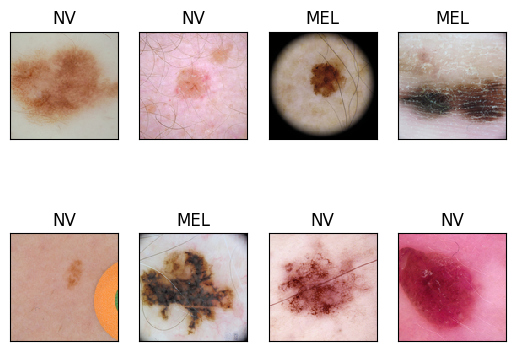

In [87]:
# Import libaries
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import os
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim



folder = ImageFolder('train', transform=torchvision.transforms.ToTensor())
loader = DataLoader(folder, batch_size=8, shuffle=True)

Xexamples, Yexamples = next(iter(loader))

for i in range(8):
    plt.subplot(2,4,i+1)  
    img = Xexamples[i].numpy().transpose(1, 2, 0)    
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] else 'MEL')
    plt.xticks([])
    plt.yticks([])

### Apply the these techniques:
- some sort of normalization such as batch normalization, layer normalization, or group normalization,
- residual connections,
- data augmentation by applying random transformations to the images,
- transfer learning using a pre-trained model (see below for some hints).

### Exploring the efficiency of ResNET50 and ResNET18 on detecting skin cancer

### Task 1: Preprocessing
***

In [88]:
def count_files(path):
    return sum([len(files) for r, d, files in os.walk(path)])

print('**training set**')
print('MEL:', count_files('train/MEL'))
print('NV:', count_files('train/NV'))

print('**validation set**')
print('MEL:', count_files('val/MEL'))
print('NV:', count_files('val/NV'))

print('**test set**')
print('TOTAL:', count_files('test_blind/blind'))

**training set**
MEL: 3213
NV: 3213
**validation set**
MEL: 626
NV: 626
**test set**
TOTAL: 1366


In [89]:
def calculate_average_image_dimensions(folder_path):
    # List of common image extensions
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']

    # Initialize variables to store total width, total height, and count of images
    total_width = 0
    total_height = 0
    image_count = 0

    # Iterate through each file in the folder
    for file in os.listdir(folder_path):
        if Path(file).suffix.lower() in image_extensions:
            try:
                # Open the image and get its dimensions
                file_path = os.path.join(folder_path, file)
                with Image.open(file_path) as img:
                    width, height = img.size
                    total_width += width
                    total_height += height
                    image_count += 1
            except Exception as e:
                print(f"Error processing {file}: {e}")

    # Calculate the average dimensions
    average_width = total_width / image_count if image_count else 0
    average_height = total_height / image_count if image_count else 0

    return average_width, average_height

print('Average dimensions of training images with melenoma:', calculate_average_image_dimensions('train/MEL'))
print('Average dimensions of training images without melenoma:', calculate_average_image_dimensions('train/NV'))

Average dimensions of training images with melenoma: (128.0, 128.0)
Average dimensions of training images without melenoma: (128.0, 128.0)


In [90]:
torch.manual_seed(42)

# Define transformations for the training data and validation data
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize images
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for validation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize images
                         std=[0.229, 0.224, 0.225])
])

# Load datasets
train_folder = ImageFolder('train', transform=train_transforms)
val_folder = ImageFolder('val', transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_folder, batch_size=32, shuffle=True)
val_loader = DataLoader(val_folder, batch_size=32, shuffle=False)



In [91]:
# Load a pre-trained ResNet-101 model
model = models.resnet101(pretrained=True)

# Freeze the layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move the model to the GPU if available
model = model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
def train_model_with_early_stopping(model, criterion, optimizer, train_loader, val_loader, epochs=25, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0

    epoch_loss_history = []
    epoch_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Training phase
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        epoch_loss_history.append(epoch_loss)
        epoch_acc_history.append(epoch_acc.item())

        # Validation phase
        model.eval()  # Set model to evaluate mode
        val_loss = 0.0
        val_corrects = 0

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.item())

        print(f'Epoch {epoch}/{epochs - 1} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Stopping early at epoch {epoch} due to no improvement in validation loss.')
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_loss_history, epoch_acc_history, val_loss_history, val_acc_history

In [ ]:
# Train the model with early stopping
model_trained, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_model_with_early_stopping(model, criterion, optimizer, train_loader, val_loader, epochs=25, patience=5)

TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

### References
***
- Anand, V., Gupta, S., Soumya Ranjan Nayak, Deepika Koundal, Prakash, D. and Verma, K.D. (2022). An automated deep learning models for classification of skin disease using Dermoscopy images: a comprehensive study. Multimedia Tools and Applications, [online] 81(26), pp.37379–37401. doi:https://doi.org/10.1007/s11042-021-11628-y.

‌